# Imports

In [1]:
!pip install optuna
!pip install darts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 24.4 MB/s eta 0:00

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna
import torch
from pytorch_lightning.callbacks import EarlyStopping
#from optuna.integration import PyTorchLightningPruningCallback  ## -- causes error --> workaround suggested on  https://github.com/optuna/optuna-examples/issues/166#issuecomment-1403112861
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback

from darts import TimeSeries
from darts.models import TransformerModel
from darts.metrics import mae
from darts.utils.likelihood_models import GaussianLikelihood

# Improving Model Performance | Target = Snowfall

## Getting Started | Import basic dataset & preprocess

In [ ]:
# for future reference - get data directly from api?
# fetch_weather_data()

In [14]:
# in the meantime use preprocessed csv with additionally added time features(refer to notebook_Anita-Gei_get_preprocessed_data.ipynb & notebook_Anita-Gei_improve_snowfall_model2.ipynb for more info)

df = pd.read_csv('/content/adj_historical_data_preprocessed.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.drop(columns='Unnamed: 0')
df = df.set_index('date')
df.tail(2)

,snowfall,weather_code_encoded,is_winter_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,...,snowfall_lag_12,precipitation_lag_12,cloud_cover_rolling_mean_3h,precipitation_rolling_std_6h,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 22:00:00,0.0,3.0,1.0,-1.911528,0.072457,-1.882966,-0.38975,-0.272951,1.403606,-0.129525,...,-0.289649,-0.389783,0.191301,-0.471575,-0.707025,1.224756,0.00051,1.414096,0.004523,1.419886
2024-01-01 23:00:00,0.0,1.0,1.0,-1.875463,-0.040453,-1.882966,-0.38975,-0.272951,1.403606,-0.280589,...,-0.289649,-0.389783,0.323438,-0.471575,-0.365944,1.366036,0.00051,1.414096,0.004523,1.419886


In [4]:
print(df.shape)

(131484, 39)


## Feature Engineering

In [57]:
df['month'] = df.index.month
df["is_winter"] = df['month'].apply(lambda x: 1 if x in [12, 1, 2] else 0)

In [48]:
# Create lag features for snowfall and precipitation
lags = [1,2,3]
for lag in lags:
    df[f'snowfall_lag_{lag}'] = df['snowfall'].shift(lag)
    df[f'precipitation_lag_{lag}'] = df['precipitation'].shift(lag)

df.tail(2)

,snowfall,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,surface_pressure,...,day_of_week_sin,day_of_week_cos,month_sin,month_cos,snowfall_lag_1,precipitation_lag_1,snowfall_lag_2,precipitation_lag_2,snowfall_lag_3,precipitation_lag_3
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 22:00:00,0.0,3.0,-1.911309,0.072451,-1.882762,-0.389763,-0.272938,1.403548,-0.129623,-1.404447,...,0.0,1.0,0.0,1.0,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763
2024-01-01 23:00:00,0.0,1.0,-1.875245,-0.040464,-1.882762,-0.389763,-0.272938,1.403548,-0.280686,-1.495166,...,0.0,1.0,0.0,1.0,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763


In [49]:
# Add rolling statistics
df['cloud_cover_rolling_mean_3h'] = df['cloud_cover'].rolling(window=3).mean()
df['precipitation_rolling_std_6h'] = df['precipitation'].rolling(window=6).std()
df['snowfall_rolling_mean_12h'] = df['snowfall'].rolling(window=12).mean()
df.tail(2)

,snowfall,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,surface_pressure,...,month_cos,snowfall_lag_1,precipitation_lag_1,snowfall_lag_2,precipitation_lag_2,snowfall_lag_3,precipitation_lag_3,cloud_cover_rolling_mean_3h,precipitation_rolling_std_6h,snowfall_rolling_mean_12h
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 22:00:00,0.0,3.0,-1.911309,0.072451,-1.882762,-0.389763,-0.272938,1.403548,-0.129623,-1.404447,...,1.0,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763,0.182911,0.0,0.0
2024-01-01 23:00:00,0.0,1.0,-1.875245,-0.040464,-1.882762,-0.389763,-0.272938,1.403548,-0.280686,-1.495166,...,1.0,0.0,-0.389763,0.0,-0.389763,0.0,-0.389763,0.309300,0.0,0.0


In [50]:
# Drop rows with NaN values (introduced by lags and rolling)
df = df.dropna()
print(df.shape)

(131485, 37)


## Use Subset of Data while finding the "best" Model!

In [5]:
train_df = df[-30000:]
print(train_df.shape)
train_df.tail(2)

(30000, 39)


,snowfall,weather_code_encoded,is_winter_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,...,snowfall_lag_12,precipitation_lag_12,cloud_cover_rolling_mean_3h,precipitation_rolling_std_6h,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 22:00:00,0.0,3.0,1.0,-1.911528,0.072457,-1.882966,-0.38975,-0.272951,1.403606,-0.129525,...,-0.289649,-0.389783,0.191301,-0.471575,-0.707025,1.224756,0.00051,1.414096,0.004523,1.419886
2024-01-01 23:00:00,0.0,1.0,1.0,-1.875463,-0.040453,-1.882966,-0.38975,-0.272951,1.403606,-0.280589,...,-0.289649,-0.389783,0.323438,-0.471575,-0.365944,1.366036,0.00051,1.414096,0.004523,1.419886


## Create Time Series

In [15]:
feature_columns = df.drop(columns=['snowfall']).columns.tolist()

snowfall_series = TimeSeries.from_dataframe(df, value_cols='snowfall')
feature_series = TimeSeries.from_dataframe(df, value_cols=feature_columns)

## Split into Train, Validation and Test Sets

In [16]:
y_train_val, y_test = snowfall_series.split_before(0.8)
y_train, y_val = y_train_val.split_before(0.8)

X_train_val, X_test = feature_series.split_before(0.8)
X_train, X_val = X_train_val.split_before(0.8)

## Eventually Select Features?

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Initialize a RandomForest and RFE
rf = RandomForestRegressor(n_estimators=100, random_state=42)
selector = RFE(estimator=rf, n_features_to_select=0.7, verbose=True)
selector = selector.fit(X_train, y_train)

# Keep only the selected features
selected_features = X_train.columns[selector.support_]
print("Selected Features:", selected_features)


## Optimize Hyperparamters with Optuna

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# Workaround to get PyTorchLightningPruningCallback working

class PyTorchLightningPruningCallback(Callback):
    """PyTorch Lightning callback to prune unpromising trials.
    See `the example <https://github.com/optuna/optuna-examples/blob/
    main/pytorch/pytorch_lightning_simple.py>`__
    if you want to add a pruning callback which observes accuracy.
    Args:
        trial:
            A :class:`~optuna.trial.Trial` corresponding to the current evaluation of the
            objective function.
        monitor:
            An evaluation metric for pruning, e.g., ``val_loss`` or
            ``val_acc``. The metrics are obtained from the returned dictionaries from e.g.
            ``pytorch_lightning.LightningModule.training_step`` or
            ``pytorch_lightning.LightningModule.validation_epoch_end`` and the names thus depend on
            how this dictionary is formatted.
    """

    def __init__(self, trial: optuna.trial.Trial, monitor: str) -> None:
        super().__init__()

        self._trial = trial
        self.monitor = monitor

    def on_validation_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        # When the trainer calls `on_validation_end` for sanity check,
        # do not call `trial.report` to avoid calling `trial.report` multiple times
        # at epoch 0. The related page is
        # https://github.com/PyTorchLightning/pytorch-lightning/issues/1391.
        if trainer.sanity_checking:
            return

        epoch = pl_module.current_epoch

        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self.monitor)
            )
            warnings.warn(message)
            return

        self._trial.report(current_score, step=epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            raise optuna.TrialPruned(message)

In [12]:
def objective(trial):
    d_model = trial.suggest_categorical("d_model", [128, 256, 512])
    nhead = trial.suggest_categorical("nhead", [4, 8])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_encoder_layers = trial.suggest_categorical("num_encoder_layers", [2, 3, 6])
    num_decoder_layers = trial.suggest_categorical("num_decoder_layers", [2, 3, 6])
    dim_feedforward = trial.suggest_categorical("dim_feedforward", [256, 512, 1024])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=12, verbose=True)
    callbacks = [pruner, early_stopper]

    # detect if a GPU is available
    if torch.cuda.is_available():
        num_workers = 4
    else:
        num_workers = 0

    pl_trainer_kwargs = {
        "accelerator": "gpu", #only on Colab!
        "devices": -1,
        "callbacks": callbacks,
    }

    # reproducibility
    torch.manual_seed(42)

    # build the Transformer model
    model = TransformerModel(
        input_chunk_length=48,
        output_chunk_length=48,
        batch_size=batch_size,
        n_epochs=100,
        nr_epochs_val_period=1,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        d_model=d_model,
        nhead=nhead,
        dim_feedforward=dim_feedforward,
        pl_trainer_kwargs=pl_trainer_kwargs,
        likelihood=GaussianLikelihood(),
        model_name="trf_model",
        force_reset=True,
        save_checkpoints=True,
    )

    # train the model
    model.fit(
        series=y_train,
        past_covariates=X_train,
        val_series=y_val,
        val_past_covariates=X_val,
    )

    # reload best model over course of training
    model = TransformerModel.load_from_checkpoint("trf_model")

    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(series=y_train, n=48)
    maes = mae(y_val[:48], preds, n_jobs=-1, verbose=True)
    mae_val = np.mean(maes)

    return mae_val if mae_val != np.nan else float("inf")


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the maes on the validation set
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10, callbacks=[print_callback])

[I 2024-12-17 14:07:21,353] A new study created in memory with name: no-name-646f2ef1-48af-4a2a-9c24-3c7c9a35c3e3
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precis

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.104


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.097


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.080


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.073


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.071


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: 0.071. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 28.28it/s]
[I 2024-12-17 14:12:21,079] Trial 0 finished with value: 0.20174661484922865 and parameters: {'d_model': 128, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 6, 'num_decoder_layers': 2, 'dim_feedforward': 512, 'lr': 0.004984987207561236}. Best is trial 0 with value: 0.20174661484922865.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Current value: 0.20174661484922865, Current params: {'d_model': 128, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 6, 'num_decoder_layers': 2, 'dim_feedforward': 512, 'lr': 0.004984987207561236}
Best value: 0.20174661484922865, Best params: {'d_model': 128, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 6, 'num_decoder_layers': 2, 'dim_feedforward': 512, 'lr': 0.004984987207561236}


INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 10.2 K | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 5.8 M  | train
8 | decoder             | Linear              | 24.7 K | train
--------------------------------------------------------------------
5.8 M     Trainable pa

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.184


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.055 >= min_delta = 0.001. New best score: 0.128


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.124 >= min_delta = 0.001. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.050 >= min_delta = 0.001. New best score: -0.047


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.103 >= min_delta = 0.001. New best score: -0.150


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: -0.150. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where yo

Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 627.04it/s]
[I 2024-12-17 14:43:30,671] Trial 1 finished with value: 0.10511434861078787 and parameters: {'d_model': 256, 'nhead': 8, 'dropout': 0.3, 'batch_size': 16, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 512, 'lr': 0.0005072694508967141}. Best is trial 1 with value: 0.10511434861078787.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Current value: 0.10511434861078787, Current params: {'d_model': 256, 'nhead': 8, 'dropout': 0.3, 'batch_size': 16, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 512, 'lr': 0.0005072694508967141}
Best value: 0.10511434861078787, Best params: {'d_model': 256, 'nhead': 8, 'dropout': 0.3, 'batch_size': 16, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 512, 'lr': 0.0005072694508967141}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 10.2 K | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 4.4

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.036


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: 0.036. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 758.60it/s]
[I 2024-12-17 14:46:10,060] Trial 2 finished with value: 0.09955440745605498 and parameters: {'d_model': 256, 'nhead': 4, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 6, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.00014948716457668321}. Best is trial 2 with value: 0.09955440745605498.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Current value: 0.09955440745605498, Current params: {'d_model': 256, 'nhead': 4, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 6, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.00014948716457668321}
Best value: 0.09955440745605498, Best params: {'d_model': 256, 'nhead': 4, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 6, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.00014948716457668321}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 10.2 K | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 6.3

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.003


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.968 >= min_delta = 0.001. New best score: 0.035


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.063 >= min_delta = 0.001. New best score: -0.028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: -0.028. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where yo

Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 757.37it/s]
[I 2024-12-17 14:50:03,941] Trial 3 finished with value: 0.06234381209525921 and parameters: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dim_feedforward': 512, 'lr': 0.0009664727437036945}. Best is trial 3 with value: 0.06234381209525921.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Current value: 0.06234381209525921, Current params: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dim_feedforward': 512, 'lr': 0.0009664727437036945}
Best value: 0.06234381209525921, Best params: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dim_feedforward': 512, 'lr': 0.0009664727437036945}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 10.2 K | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 11.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.185


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.164


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.066 >= min_delta = 0.001. New best score: 0.098


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.091


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.077


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: 0.077. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 747.78it/s]
[I 2024-12-17 15:10:44,563] Trial 4 finished with value: 0.19149782403163415 and parameters: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 16, 'num_encoder_layers': 6, 'num_decoder_layers': 6, 'dim_feedforward': 1024, 'lr': 0.0011855825265444833}. Best is trial 3 with value: 0.06234381209525921.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Current value: 0.19149782403163415, Current params: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 16, 'num_encoder_layers': 6, 'num_decoder_layers': 6, 'dim_feedforward': 1024, 'lr': 0.0011855825265444833}
Best value: 0.06234381209525921, Best params: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dim_feedforward': 512, 'lr': 0.0009664727437036945}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 20.5 K | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 8.7

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-17 15:11:13,974] Trial 5 pruned. Trial was pruned at epoch 0.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Current value: 0.2018910318559367, Current params: {'d_model': 512, 'nhead': 8, 'dropout': 0.3, 'batch_size': 16, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dim_feedforward': 256, 'lr': 0.007225597221699876}
Best value: 0.06234381209525921, Best params: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dim_feedforward': 512, 'lr': 0.0009664727437036945}


INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | eval 
1 | train_criterion     | MSELoss             | 0      | eval 
2 | val_criterion       | MSELoss             | 0      | eval 
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 10.2 K | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 5.5 M  | train
8 | decoder             | Linear              | 24.7 K | train
--------------------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.284    Total estimated model params size (MB)
115       Modules in train mode
3         Modules in e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.095


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.086


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-17 15:21:40,853] Trial 6 pruned. Trial was pruned at epoch 13.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Current value: 0.14356646343885227, Current params: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 16, 'num_encoder_layers': 6, 'num_decoder_layers': 3, 'dim_feedforward': 512, 'lr': 0.008446521462340834}
Best value: 0.06234381209525921, Best params: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dim_feedforward': 512, 'lr': 0.0009664727437036945}


INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | eval 
1 | train_criterion     | MSELoss             | 0      | eval 
2 | val_criterion       | MSELoss             | 0      | eval 
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 10.2 K | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 2.8 M  | train
8 | decoder             | Linear              | 24.7 K | train
--------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.223    Total estimated model params size (MB)
75        Modules in train mode
3         Modules in e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.040


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.062 >= min_delta = 0.001. New best score: -0.022


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.107 >= min_delta = 0.001. New best score: -0.128


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: -0.128. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where yo

Predicting: |          | 0/? [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00, 387.18it/s]
[I 2024-12-17 15:24:09,475] Trial 7 finished with value: 0.10245682703762234 and parameters: {'d_model': 256, 'nhead': 4, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.0005707261807526591}. Best is trial 3 with value: 0.06234381209525921.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Current value: 0.10245682703762234, Current params: {'d_model': 256, 'nhead': 4, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.0005707261807526591}
Best value: 0.06234381209525921, Best params: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dim_feedforward': 512, 'lr': 0.0009664727437036945}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | eval 
1 | train_criterion     | MSELoss             | 0      | eval 
2 | val_criterion       | MSELoss             | 0      | eval 
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 20.5 K | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 11.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-17 15:24:44,751] Trial 8 pruned. Trial was pruned at epoch 0.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | eval 
1 | train_criterion     | MSELoss             | 0      | eval 
2 | val_crite

Current value: 0.2094676113729612, Current params: {'d_model': 512, 'nhead': 4, 'dropout': 0.3, 'batch_size': 16, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.0009594845217000532}
Best value: 0.06234381209525921, Best params: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dim_feedforward': 512, 'lr': 0.0009664727437036945}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-17 15:25:10,503] Trial 9 pruned. Trial was pruned at epoch 0.


Current value: 0.1694127618194828, Current params: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 16, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dim_feedforward': 512, 'lr': 0.0018417098461832552}
Best value: 0.06234381209525921, Best params: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dim_feedforward': 512, 'lr': 0.0009664727437036945}


In [13]:
# Print best parameters
print(study.best_value)
print(f"Best trial: {study.best_trial.params}")

0.06234381209525921
Best trial: {'d_model': 256, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dim_feedforward': 512, 'lr': 0.0009664727437036945}


## Initialize Model with optimized Parameters

In [24]:
#fill after completing optuna study! | Use whole dataset then!

#early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=12, verbose=True)
#callbacks = [early_stopper]

pl_trainer_kwargs ={
        "accelerator": "gpu", #only on Colab!
        "devices": -1,
        #"callbacks": callbacks,
    }

model = TransformerModel(
    input_chunk_length=48,
    output_chunk_length=48,
    batch_size=64,
    n_epochs=16, # derived from optimization with early stopping
    nr_epochs_val_period=1,
    dropout=0.1,
    optimizer_kwargs={"lr": 0.0009664727437036945},
    num_encoder_layers=3,
    num_decoder_layers=6,
    d_model=256,
    nhead=8,
    dim_feedforward=512,
    pl_trainer_kwargs=pl_trainer_kwargs,
    likelihood=GaussianLikelihood(),
    model_name="snowfall_model",
    force_reset=True,
    random_state=42
    )

## Fit Model - on whole dataset!

In [26]:
model.fit(
    series=y_train,
    past_covariates=X_train,
    val_series=y_val,
    val_past_covariates=X_val,
    verbose=True
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | eval 
1 | train_criterion     | MSELoss             | 0      | eval 
2 | val_criterion       | MSELoss             | 0      | eval 
3 | train_metrics      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=16` reached.


TransformerModel(output_chunk_shift=0, d_model=256, nhead=8, num_encoder_layers=3, num_decoder_layers=6, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=48, output_chunk_length=48, batch_size=64, n_epochs=16, nr_epochs_val_period=1, optimizer_kwargs={'lr': 0.0009664727437036945}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': -1}, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), model_name=snowfall_model, force_reset=True, random_state=42)

# Save Model

In [27]:
model.save("new_snowfall_model.pt")

## Make Predictions

In [28]:
forecast = model.predict(n=48, series=y_train_val, past_covariates=X_train_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [29]:
forecast.values()

array([[ 1.20175667e-01],
       [-7.38916460e-02],
       [ 2.09599720e-01],
       [ 3.82588166e-01],
       [ 5.65166316e-02],
       [-2.59935682e-01],
       [ 2.32998560e-01],
       [-1.44083324e-01],
       [-5.82572667e-02],
       [ 2.68987796e-01],
       [ 3.36271411e-02],
       [ 8.68451661e-02],
       [-1.49623734e-01],
       [-4.00029983e-01],
       [ 4.77240929e-02],
       [ 2.67340295e-01],
       [ 2.69715015e-01],
       [ 1.01804305e-02],
       [ 2.07595760e-02],
       [-4.81314714e-03],
       [-6.19992352e-02],
       [-7.18669118e-03],
       [-4.92897486e-02],
       [-2.23230595e-02],
       [-3.61882207e-02],
       [-1.16610114e-01],
       [ 1.10716174e-01],
       [ 2.38175950e-02],
       [-3.75634104e-01],
       [-4.38401068e-02],
       [ 9.43370578e-02],
       [ 2.30556968e-01],
       [ 2.22820317e-01],
       [ 5.13045069e-02],
       [-3.18521811e-01],
       [ 1.84371877e-01],
       [ 6.42080403e-02],
       [-6.00853809e-02],
       [-8.7

## Backtesting and Historical Forecasting

In [ ]:
historical_forecast = model.historical_forecasts(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=6,
    retrain=True,
    overlap_end=True,
    verbose=True
)

error_mae = mae(snowfall_series.slice_intersect(historical_forecast), historical_forecast)


  0%|          | 0/5260 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | eval 
1 | train_criterion     | MSELoss             | 0      | eval 
2 | val_criterion       | MSELoss            

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
error_mae

0.19774705079184304

# Plot historical forecast vs actuals

NameError: name 'plt' is not defined

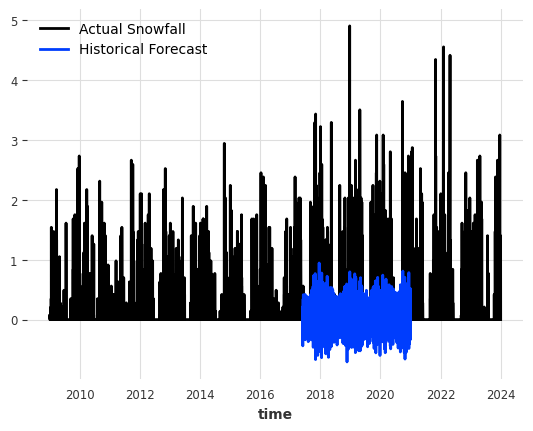

In [ ]:
snowfall_series.plot(label="Actual Snowfall")
historical_forecast.plot(label="Historical Forecast")
plt.legend()
plt.show();

## Backtest Snowfall Model

In [ ]:
backtest_mae = model.backtest(
    series=y_test,
    past_covariates=X_test,
    start=0.7,
    forecast_horizon=48,
    stride=10,
    retrain=False,
    metric=mae,
    verbose=True
)

print(f"Backtest MAE: {backtest_mae}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Backtest MAE: 0.16154238046205646
